## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns
from itertools import chain
from random import sample 
import scipy

import sklearn.model_selection as skl
import tensorflow as tf
from skimage import io

from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')

all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}

print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

all_xray_df.sample(5)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
58088,00014368_009.png,No Finding,9,14368,62,F,PA,2544,2756,0.139000,0.139000,NaN,/data/images_007/images/00014368_009.png
19443,00005162_000.png,No Finding,0,5162,29,M,AP,2500,2048,0.171000,0.171000,NaN,/data/images_003/images/00005162_000.png
2166,00000571_001.png,Effusion|Infiltration|Pleural_Thickening,1,571,56,M,PA,2021,2021,0.194311,0.194311,NaN,/data/images_001/images/00000571_001.png
23339,00006191_000.png,Atelectasis|Infiltration,0,6191,59,F,PA,2500,2048,0.171000,0.171000,NaN,/data/images_003/images/00006191_000.png
87478,00021610_025.png,Pneumothorax,25,21610,45,M,PA,2992,2991,0.143000,0.143000,NaN,/data/images_010/images/00021610_025.png


In [3]:
d = pd.read_csv('/data/Data_Entry_2017.csv')

In [4]:
d['path'] = d['Image Index'].map(all_image_paths.get)

d.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
42434,00010914_010.png,Fibrosis,10,10914,50,M,PA,2882,2817,0.143,0.143,NaN,/data/images_005/images/00010914_010.png
59407,00014677_008.png,No Finding,8,14677,43,F,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014677_008.png
62350,00015425_000.png,No Finding,0,15425,50,F,PA,2992,2991,0.143,0.143,NaN,/data/images_007/images/00015425_000.png


In [5]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Todo

all_labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]

print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        d[c_label] = d['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)

d.sample(3)


All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
46144,00011810_008.png,No Finding,8,11810,54,M,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
57849,00014327_000.png,No Finding,0,14327,40,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
55463,00013894_033.png,Atelectasis,33,13894,21,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
len(d)

112120

In [7]:
d.head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

# Todo

d['pneumonia_class']=d['Pneumonia'].replace({0.0:'Negative',1.0:'Positive'})
d[d['pneumonia_class']== 'Positive'].head(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,Positive
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Positive
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,Positive


In [9]:
d[d['pneumonia_class']== 'Negative'].head(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Negative


## Create your training and testing data:

In [10]:
def create_splits(d): 
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
       

        train_df, valid_df = skl.train_test_split(d, 
                                   test_size = 0.2, 
                                   stratify = d['Pneumothorax'],
                                    random_state=42)
    
                
        return train_df, valid_df
    
    
train_df, valid_df = create_splits(d)
    
    
print("Train Pneumothorax Ratio:", train_df['Pneumothorax'].sum() / len(train_df))
print("Valid Pneumothorax Ratio:", valid_df['Pneumothorax'].sum() / len(valid_df))

        

Train Pneumothorax Ratio: 0.047293078844095615
Valid Pneumothorax Ratio: 0.047270781305743845


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [11]:
def my_image_augmentation():
     
    #Create training ImageDataGenerator with appropriate augmentations for medical imaging.
        
    
    # Todo
    # Training data augmentation
    
    train_idg = ImageDataGenerator(rescale=1.0 / 255.0,
                            horizontal_flip=True,  # Suitable for chest X-rays
                            vertical_flip=False,  # Inappropriate for medical imaging
                            height_shift_range=0.1,
                            width_shift_range=0.1,
                            rotation_range=20,    # Small rotations for patient positioning
                            shear_range=0.1,      # Small shear to avoid anatomical distortion
                            zoom_range=0.1,       # Small zoom for scaling variations
                            brightness_range=[0.9, 1.1])  # Slight brightness adjustment
              
    # Todo
    # Create Validation data augmentation (minimal, only rescaling)
        
    val_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1 )  # Only rescale for validation
    
    
    return train_idg, val_idg
    
       
def make_train_gen(dataframe, directory, img_size, batch_size=32):
    """Create a training data generator using flow_from_dataframe."""
    
    train_idg, _ = my_image_augmentation()  # Get training ImageDataGenerator
    
    train_gen = train_idg.flow_from_dataframe(
                            dataframe=dataframe,
                            directory=directory,
                            x_col='path',
                            y_col='pneumonia_class',
                            class_mode='binary',
                            target_size=IMG_SIZE,
                            batch_size=32,
                            shuffle=True )  # Shuffle for training
   
    return train_gen

def make_val_gen(dataframe, directory, img_size, batch_size=32):
    """Create a validation data generator using flow_from_dataframe."""
    
    _, val_idg = my_image_augmentation()  # Get validation ImageDataGenerator
    
    val_gen = val_idg.flow_from_dataframe(
                            dataframe=dataframe,
                            directory=directory,
                            x_col='path',
                            y_col='pneumonia_class',
                            class_mode='binary',
                            target_size=IMG_SIZE,
                            batch_size=32,
                            shuffle=False)  # No shuffling for validation
    
    return val_gen



if __name__ == "__main__":
    
    # Example DataFrame and parameters (replace with actual data)
    
    train_df = pd.DataFrame({
        'path': ['img1.jpg', 'img2.jpg'],  # Example image filenames
        'pneumonia_class': ['0', '1']      # Example binary labels
    })
    
    valid_df = pd.DataFrame({
        'path': ['img3.jpg', 'img4.jpg'],
        'pneumonia_class': ['0', '1']
    })
    
    IMG_SIZE = (224, 224)  # Example image size
     
    DIRECTORY = './images/'  # Example directory path
   
    # Create generators
    train_gen = make_train_gen(train_df, DIRECTORY, IMG_SIZE)
    val_gen = make_val_gen(valid_df, DIRECTORY, IMG_SIZE)
    
    
    # Pull a single batch of validation data for testing after each epoch
    valX, valY = next(val_gen)  # Use next() to get one batch
    print(f"Validation batch shape: X={valX.shape}, Y={valY.shape}")
    
    

Found 0 validated image filenames belonging to 0 classes.
Found 0 validated image filenames belonging to 0 classes.
Validation batch shape: X=(0, 224, 224, 3), Y=(0,)


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/dataframe_iterator.py:273: UserWarning: Found 2 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [12]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    my_idg = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      height_shift_range = 0.1,
                                      width_shift_range = 0.1,
                                      rotation_range = 15,
                                      shear_range = 0.1,
                                      zoom_range = 0.1, 
                                      samplewise_center = True,
                                      samplewise_std_normalization = True
                                     )
    
    return my_idg

def make_train_gen(*vargs):
    
    train_gen = vargs[0].flow_from_dataframe(dataframe=vargs[1], 
                                          directory=None, 
                                          x_col = 'path',
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (224,224), 
                                          batch_size = 16
                                          )
    return train_gen

def make_val_gen(*vargs):
    
    val_gen = vargs[0].flow_from_dataframe(dataframe = vargs[1], 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (224,224), 
                                              batch_size = 32,
                                              shuffle=False
                                             )
    
    return val_gen

    

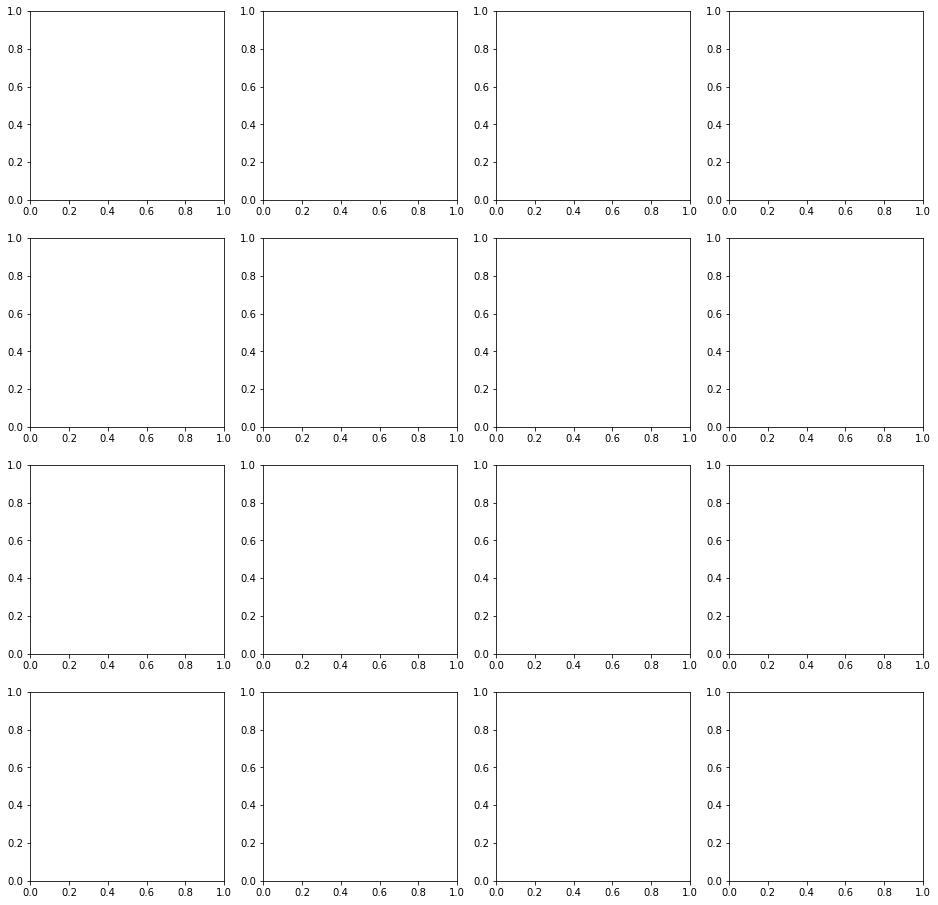

In [19]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentatio



t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
    
    

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [30]:
#def load_pretrained_model():
    
    # Todo
    
model = VGG16(include_top=True, weights='imagenet')
    #transfer_layer = model.get_layer(lay_of_interest)
    #vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
#    return vgg_model
       
model.summary()
    
    


Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
def build_my_model(vargs):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [ ]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

# weight_path="{}_my_model.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, 
#                              monitor= CHOOSE_METRIC_TO_MONITOR_FOR_PERFORMANCE, 
#                              verbose=1, 
#                              save_best_only=True, 
#                              mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                              save_weights_only = True)

# early = EarlyStopping(monitor= SAME_AS_METRIC_CHOSEN_ABOVE, 
#                       mode= CHOOSE_MIN_OR_MAX_FOR_YOUR_METRIC, 
#                       patience=10)

# callbacks_list = [checkpoint, early]

### Start training! 

In [ ]:
## train your model

# Todo

# history = my_model.fit_generator(train_gen, 
#                           validation_data = (valX, valY), 
#                           epochs = , 
#                           callbacks = callbacks_list)

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [ ]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
pred_Y = new_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    
    return

## what other performance statistics do you want to include here besides AUC? 


# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    # Todo
    return

In [ ]:
## plot figures

# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)